# Convolutional Recurrent Neural Network for Optical Character Recognition

## Importing the packages

In [ ]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time

from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

### Dataset

You can directly download the full dataset in [this link](https://www.robots.ox.ac.uk/~vgg/data/text/#sec-synth). Since it is a huge dataset, we have used only the subset of the original dataset. The subset dataset is available in this [this link](https://drive.google.com/file/d/1SeH5VjSSCFWDVVXVK0nThlKht5xjqdiB/view?usp=share_link)

### Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/90kDICT32px.zip -d /content/90kDICT32px/

Streaming output truncated to the last 5000 lines.
  inflating: /content/90kDICT32px/8/3/448_BRIDGETOWN_9521.jpg  
  inflating: /content/90kDICT32px/8/3/449_triathletes_80584.jpg  
  inflating: /content/90kDICT32px/8/3/44_LESSEPS_44140.jpg  
  inflating: /content/90kDICT32px/8/3/450_lathes_43509.jpg  
  inflating: /content/90kDICT32px/8/3/451_Botch_8928.jpg  
  inflating: /content/90kDICT32px/8/3/452_nosing_52336.jpg  
  inflating: /content/90kDICT32px/8/3/453_Sew_69741.jpg  
  inflating: /content/90kDICT32px/8/3/454_Wilbur_86564.jpg  
  inflating: /content/90kDICT32px/8/3/455_LABIA_43005.jpg  
  inflating: /content/90kDICT32px/8/3/456_EXPROPRIATORS_27542.jpg  
  inflating: /content/90kDICT32px/8/3/457_pui_61154.jpg  
  inflating: /content/90kDICT32px/8/3/458_BARBARISM_5882.jpg  
  inflating: /content/90kDICT32px/8/3/459_immobilizes_38114.jpg  
  inflating: /content/90kDICT32px/8/3/45_Subscriptions_75669.jpg  
  inflating: /content/90kDICT32px/8/3/460_repack_64715.jpg  
  inflating: /c

In [ ]:
characterset = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# This function converts the characters in the text to numberical ids
def text2ids(txt):
    encoded_list = []
    for index, char in enumerate(txt):
        try:
            encoded_list.append(characterset.index(char))
        except:
            print(char)
    return encoded_list

In [ ]:
# This function resizes the image with (32, 128, 1)
def rescale_img(img):
    # convert each image of shape (32, 128, 1)
    w, h = img.shape
    if h > 128 or w > 32:
        return "SKIP"
    if w < 32:
        add_zeros = np.ones((32-w, h))*255
        img = np.concatenate((img, add_zeros))

    if h < 128:
        add_zeros = np.ones((32, 128-h))*255
        img = np.concatenate((img, add_zeros), axis=1)
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.
    return img

In [ ]:
images_training = []
text_training = []
len_train_input = []
len_training_label = []
original_txt_training = []

In [ ]:
images_testing = []
text_testing = []
len_testing_input = []
len_testing_label = []
original_txt_testing = []

In [ ]:
path = '/content/90kDICT32px'

# Data Preparation

In [ ]:
max_label_len = 0

i=0
for root, dirnames, filenames in os.walk(path):
 
    for name in fnmatch.filter(filenames, '*.jpg'):
        # read input image and convert into gray scale image
        img = cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_BGR2GRAY)   
 
        img = rescale_img(img)
        if img == "SKIP":
            continue
        # get the text from the image
        txt = name.split('_')[1]
        
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
           
        if i%10 == 0:     
            original_txt_testing.append(txt)   
            len_testing_label.append(len(txt))
            len_testing_input.append(31)
            images_testing.append(img)
            text_testing.append(text2ids(txt))
        else:
            original_txt_training.append(txt)   
            len_training_label.append(len(txt))
            len_train_input.append(31)
            images_training.append(img)
            text_training.append(text2ids(txt)) 
        i=i+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
train_padded_txt = pad_sequences(text_training, maxlen=max_label_len, padding='post', value = len(characterset))
valid_padded_txt = pad_sequences(text_testing, maxlen=max_label_len, padding='post', value = len(characterset))

# Model Architecture

In [ ]:
inputs = Input(shape=(32,128,1))
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
outputs = Dense(len(characterset)+1, activation = 'softmax')(blstm_2)

actual_model = Model(inputs, outputs)

In [ ]:
actual_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 32, 256)        2951

## CTC Loss Function (Spectial loss function for OCR problem)

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

## Model Training

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
images_training = np.array(images_training)
len_train_input = np.array(len_train_input)
len_training_label = np.array(len_training_label)

images_testing = np.array(images_testing)
len_testing_input = np.array(len_testing_input)
len_testing_label = np.array(len_testing_label)

In [ ]:
batch_size = 64
epochs = 10
model.fit(x=[images_training, train_padded_txt, len_train_input, len_training_label], y=np.zeros(len(images_training)), batch_size=batch_size, epochs = epochs, validation_data = ([images_testing, valid_padded_txt, len_testing_input, len_testing_label], [np.zeros(len(images_testing))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/10
1459/1459 [==============================] - ETA: 0s - loss: 26.3263
Epoch 1: val_loss improved from inf to 24.13691, saving model to best_model.hdf5
1459/1459 [==============================] - 153s 92ms/step - loss: 26.3263 - val_loss: 24.1369
Epoch 2/10
1459/1459 [==============================] - ETA: 0s - loss: 17.4371
Epoch 2: val_loss improved from 24.13691 to 10.18490, saving model to best_model.hdf5
1459/1459 [==============================] - 125s 86ms/step - loss: 17.4371 - val_loss: 10.1849
Epoch 3/10
1459/1459 [==============================] - ETA: 0s - loss: 6.6358
Epoch 3: val_loss improved from 10.18490 to 5.08855, saving model to best_model.hdf5
1459/1459 [==============================] - 127s 87ms/step - loss: 6.6358 - val_loss: 5.0886
Epoch 4/10
1459/1459 [==============================] - ETA: 0s - loss: 4.6133
Epoch 4: val_loss improved from 5.08855 to 4.57463, saving model to best_model.hdf5
1459/1459 [==============================] - 129s 88ms/step 

## Predictions

In [ ]:
# load the saved best model weights
actual_model.load_weights('best_model.hdf5')
 
# predict outputs on validation images
predicted = actual_model.predict(images_testing[:10])
 
# use CTC decoder
output = K.get_value(K.ctc_decode(predicted, input_length=np.ones(predicted.shape[0])*predicted.shape[1],
                         greedy=True)[0][0])

1/1 [==============================] - 2s 2s/step


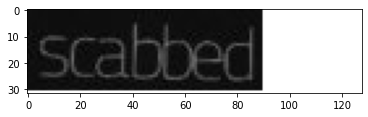

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images_testing[0].reshape(32,128), cmap='gray')
plt.show()

-----------------Input Image-------------------


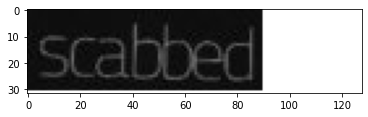

predicted text = scabbed

-----------------Input Image-------------------


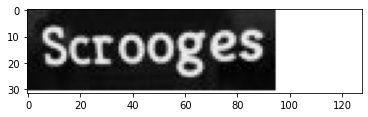

predicted text = Scrooges

-----------------Input Image-------------------


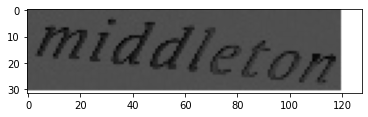

predicted text = middleton

-----------------Input Image-------------------


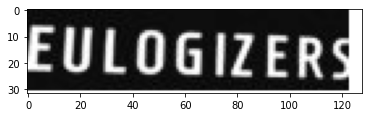

predicted text = EULOGIZERS

-----------------Input Image-------------------


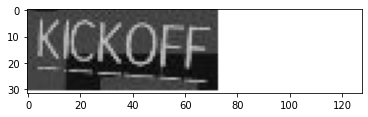

predicted text = KICKOFE

-----------------Input Image-------------------


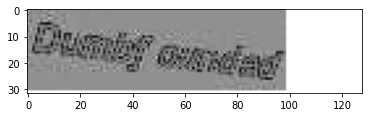

predicted text = Cuodyomediad

-----------------Input Image-------------------


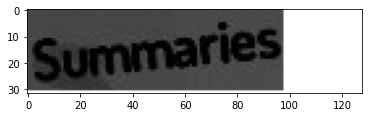

predicted text = Summaries

-----------------Input Image-------------------


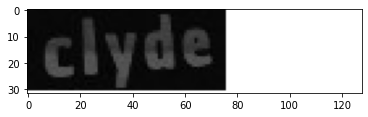

predicted text = clyde

-----------------Input Image-------------------


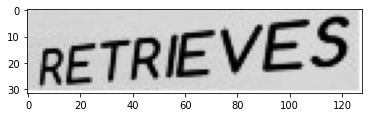

predicted text = RETRIEVES

-----------------Input Image-------------------


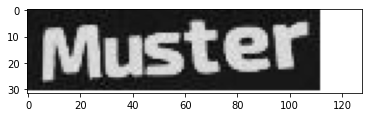

predicted text = Muster



In [ ]:
i = 0
for word in output:
    print("-----------------Input Image-------------------")
    plt.imshow(images_testing[i].reshape(32,128), cmap='gray')
    plt.show()
    print("predicted text = ", end = '')
    for char in word:  
        if int(char) != -1:
            print(characterset[int(char)], end = '')       
    print('\n')
    i+=1